### Importing Libraries

In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV

# importing classification metrics 
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,recall_score,precision_score,roc_curve,auc,roc_auc_score

### Loading the data

In [2]:
data1 = pd.read_csv('top_1000_pe_imports.csv')
normal1 = pd.read_csv('API_Khaled_Dell_Dec22.csv')
normal2 = pd.read_csv('API_Khaled_Lenovo_Dec22.csv')
normal3 = pd.read_csv('API_Normal_VMH_Nov22.csv')
###################################################################################
malware1 = pd.read_csv('API_Malware_Data_Dec22.csv')
malware2 = pd.read_csv('malware_api.csv')

In [3]:
normal = normal1.append(normal2,ignore_index = True).append(normal3,ignore_index = True)
normal['malware'] = 0
malware = malware1.append(malware2,ignore_index = True)
malware['malware'] = 1
data2 = normal.append(malware,ignore_index = True)

In [7]:
data = data1.append(data2,ignore_index = True)
data.shape

(305297, 1001)

In [8]:
data = data[~(data.sum(axis = 1) == 0)]
data.shape

(256194, 1001)

In [6]:
# checking dulicates
print("Number of duplicated raws: ",data.duplicated().sum())
# dropping duplicated raws
data = data.drop_duplicates(keep='first')
# checking the shape of the data
print("Shape of the Data: ",data.shape)

Number of duplicated raws:  233955
Shape of the Data:  (22239, 1001)


### Shuffling the data

In [9]:
# shuffling the data
data = data.sample(frac=1,random_state=1)

In [11]:
data['malware'].value_counts()

0    129539
1    126655
Name: malware, dtype: int64

### Splitting the data into X and Y

In [12]:
X = data.drop(columns = ['malware'])
# X = data.drop(columns = ['md5','Name','Machine','Class']).values
y = data['malware']

print("Shape of features: ",X.shape)
print("Shape of label: ",y.shape)

Shape of features:  (256194, 1000)
Shape of label:  (256194,)


In [13]:
data['malware'].value_counts(normalize = True)*100

0    50.562855
1    49.437145
Name: malware, dtype: float64

### Splitting the data into Training and Testing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=2,stratify=y)

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (204955, 1000)
y_train shape:  (204955,)
X_test shape:  (51239, 1000)
y_test shape:  (51239,)


### Defining the Important features

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train,y_train)
importances= pd.DataFrame({'Feature': X_train.columns, 'Importance': np.round((rf.feature_importances_ * 100),3)})
importances= importances.sort_values('Importance', ascending=False).set_index('Feature')

importances.loc[importances['Importance']> 0.2]

,Importance
Feature,
_CorExeMain,6.127
GetCurrentThreadId,4.807
GetCurrentProcessId,3.896
UnhandledExceptionFilter,3.587
QueryPerformanceCounter,3.586
...,...
GetCommandLineA,0.210
GetACP,0.206
GetFileVersionInfoSizeA,0.205


In [16]:
features= importances.loc[importances['Importance']> 0.2].index.to_list()
mal= ['malware']
columns= features + mal

In [17]:
features

['_CorExeMain',
 'GetCurrentThreadId',
 'GetCurrentProcessId',
 'UnhandledExceptionFilter',
 'QueryPerformanceCounter',
 'TerminateProcess',
 'GetCurrentProcess',
 'Sleep',
 'GetProcAddress',
 'EnterCriticalSection',
 'MultiByteToWideChar',
 'InitializeSListHead',
 'HeapAlloc',
 'GetSystemTimeAsFileTime',
 'memcpy',
 'SetUnhandledExceptionFilter',
 'malloc',
 'ExitProcess',
 'CloseHandle',
 'GetTempFileNameA',
 '_initterm',
 'RegCloseKey',
 '__p__fmode',
 'RaiseException',
 'FreeLibrary',
 'memset',
 'DeleteCriticalSection',
 'GetTickCount',
 '_cexit',
 '__p__commode',
 'LeaveCriticalSection',
 'wsprintfA',
 'WaitForSingleObject',
 'CreateFileMappingA',
 'WideCharToMultiByte',
 'GetModuleHandleExW',
 'free',
 'SetFileAttributesA',
 'GetLastError',
 'VirtualAlloc',
 'DosDateTimeToFileTime',
 'GetDC',
 'GetEnvironmentStrings',
 'GetModuleHandleA',
 'ExitWindowsEx',
 'CloseEventLog',
 'SetLastError',
 'LoadLibraryA',
 'GetModuleHandleW',
 'GetDlgItemTextA',
 'GetTempPathA',
 'VirtualProte

In [18]:
data=data[columns]
data.shape

(256194, 99)

In [19]:
X = data.drop(columns = ['malware'])
y = data['malware']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=2,stratify=y)

In [20]:
def plot_roc_curve(roc_auc_train, roc_auc_test):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Random Forest

Train Accuracy:  0.9180210290063673
Train Precision:  0.8661243372491944
Train Recall:  0.9866862737357388
Train F1 Score:  0.9224828375286042
Test Accuracy:  0.917348113741486
Test Precision:  0.865792759051186
Test Recall:  0.9855907780979827
Test F1 Score:  0.9218158657485184


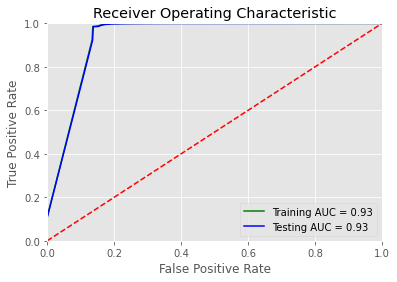

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=3, bootstrap= True,max_depth= 110,
                            max_features= 3,min_samples_leaf= 2,min_samples_split= 3, class_weight = 'balanced')
rf.fit(X_train,y_train)
rf.fit(X_train, y_train)
##############################################
train_predict = rf.predict(X_train)
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))

test_predict = rf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
##################################################
y_pred_train_prob = rf.predict_proba(X_train)[:,1]
y_pred_test_prob = rf.predict_proba(X_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)
plot_roc_curve(roc_auc_train, roc_auc_test)
########################################################
with open('rf_model_api.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [22]:
def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))

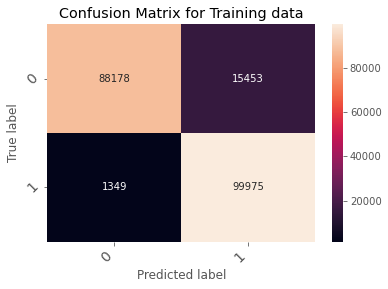

In [23]:
plot_conf_matrix(confusion_matrix(y_train, train_predict), "Training data")

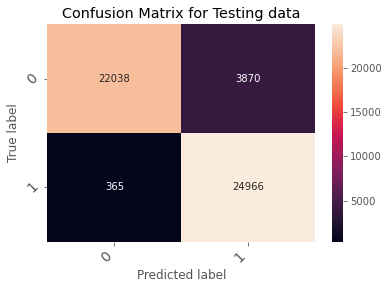

In [24]:
plot_conf_matrix(confusion_matrix(y_test, test_predict), "Testing data")

# Decision Tree

Train Accuracy:  0.9283452465175283
Train Precision:  0.876438179985401
Train Recall:  0.9953910228573685
Train F1 Score:  0.9321349353049908
Test Accuracy:  0.9236909385429067
Test Precision:  0.8717761810545316
Test Recall:  0.9914728988196281
Test F1 Score:  0.9277798300701884


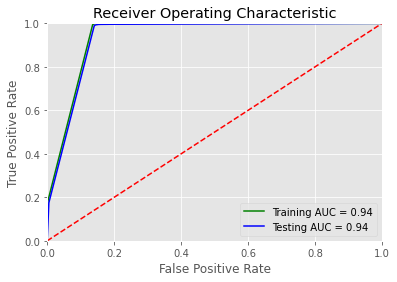

In [38]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=100, random_state=0)
dt.fit(X_train, y_train)
##############################################
train_predict = dt.predict(X_train)
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))

test_predict = dt.predict(X_test)

print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
##################################################
y_pred_train_prob = dt.predict_proba(X_train)[:,1]
y_pred_test_prob = dt.predict_proba(X_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)
plot_roc_curve(roc_auc_train, roc_auc_test)
########################################################
with open('dt_model_api.pkl', 'wb') as f:
    pickle.dump(dt, f)

# KNN

In [45]:
# from sklearn.neighbors import KNeighborsClassifier 
# knn = KNeighborsClassifier(n_neighbors = 30)
# knn.fit(X_train, y_train)
# ##########################################################################
# train_predict = knn.predict(X_train)
# print("Train Accuracy: ",accuracy_score(y_train,train_predict))
# print("Train Precision: ",precision_score(y_train,train_predict))
# print("Train Recall: ",recall_score(y_train,train_predict))
# print("Train F1 Score: ",f1_score(y_train,train_predict))

# test_predict = knn.predict(X_test)
# print("Test Accuracy: ",accuracy_score(y_test,test_predict))
# print("Test Precision: ",precision_score(y_test,test_predict))
# print("Test Recall: ",recall_score(y_test,test_predict))
# print("Test F1 Score: ",f1_score(y_test,test_predict))
# ####################################################################
# y_pred_train_prob = knn.predict_proba(X_train)[:,1]
# y_pred_test_prob = knn.predict_proba(X_test)[:,1]

# fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
# roc_auc_train = auc(fpr_tr, tpr_tr)

# fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
# roc_auc_test = auc(fpr_ts, tpr_ts)
# plot_roc_curve(roc_auc_train, roc_auc_test)

# with open('knn_model_api.pkl', 'wb') as f:
#     pickle.dump(knn, f)

# Linear Discrimnant Analysis (LDA)

Train Accuracy:  0.9158546998121538
Train Precision:  0.8682269677487168
Train Recall:  0.9782677351861355
Train F1 Score:  0.9199684440113229
Test Accuracy:  0.9154550244930619
Test Precision:  0.8671795768490995
Test Recall:  0.9789191109707474
Test F1 Score:  0.9196676927641584


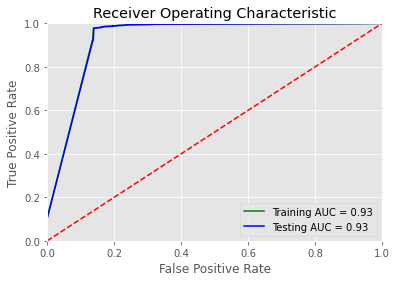

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
##########################################################################
train_predict = lda.predict(X_train)
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))

test_predict = lda.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
####################################################################
y_pred_train_prob = lda.predict_proba(X_train)[:,1]
y_pred_test_prob = lda.predict_proba(X_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)
plot_roc_curve(roc_auc_train, roc_auc_test)

with open('lda_model_api.pkl', 'wb') as f:
    pickle.dump(lda, f)

# Logistic Regression

Train Accuracy:  0.9185040618672391
Train Precision:  0.8683882876372406
Train Recall:  0.9843373731791086
Train F1 Score:  0.9227346109900684
Test Accuracy:  0.9178555397255996
Test Precision:  0.8670837678136948
Test Recall:  0.9848012316923928
Test F1 Score:  0.9222010683721188


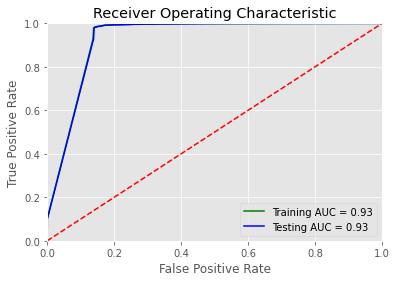

In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1', C = 100, solver='liblinear')
lr.fit(X_train, y_train)
##########################################################################
train_predict = lr.predict(X_train)
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))

test_predict = lr.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
####################################################################
y_pred_train_prob = lr.predict_proba(X_train)[:,1]
y_pred_test_prob = lr.predict_proba(X_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)
plot_roc_curve(roc_auc_train, roc_auc_test)

with open('lr_model_api.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Naive Bayes

Train Accuracy:  0.8753775218950501
Train Precision:  0.8075917717922492
Train Recall:  0.9818404326714303
Train F1 Score:  0.8862322390984813
Test Accuracy:  0.8762661254122837
Test Precision:  0.808065405703533
Test Recall:  0.9832616162014922
Test F1 Score:  0.887096199736439


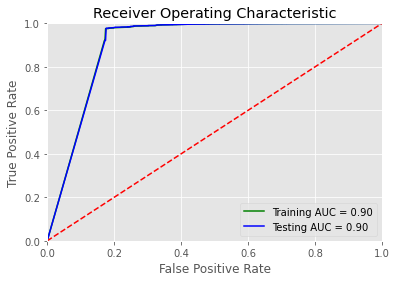

In [42]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
##########################################################################
train_predict = nb.predict(X_train)
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))

test_predict = nb.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
####################################################################
y_pred_train_prob = nb.predict_proba(X_train)[:,1]
y_pred_test_prob = nb.predict_proba(X_test)[:,1]

fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)
plot_roc_curve(roc_auc_train, roc_auc_test)

with open('nb_model_api.pkl', 'wb') as f:
    pickle.dump(nb, f)

# Combining Graphs

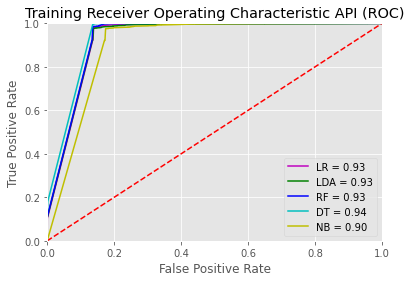

In [47]:
# training curves
y_pred_train_prob = lr.predict_proba(X_train)[:,1]
fpr_tr_lr, tpr_tr_lr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_lr, tpr_tr_lr)
plt.plot(fpr_tr_lr, tpr_tr_lr, 'm', label = 'LR = %0.2f' % roc_auc_train)
#####################################################################
y_pred_train_prob = lda.predict_proba(X_train)[:,1]
fpr_tr_lda, tpr_tr_lda, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_lda, tpr_tr_lda)
plt.plot(fpr_tr_lda, tpr_tr_lda, 'g', label = 'LDA = %0.2f' % roc_auc_train)
########################################################################
y_pred_train_prob = rf.predict_proba(X_train)[:,1]
fpr_tr_rf, tpr_tr_rf, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_rf, tpr_tr_rf)
plt.plot(fpr_tr_rf, tpr_tr_rf, 'b', label = 'RF = %0.2f' % roc_auc_train)
######################################################################
y_pred_train_prob = dt.predict_proba(X_train)[:,1]
fpr_tr_dt, tpr_tr_dt, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_dt, tpr_tr_dt)
plt.plot(fpr_tr_dt, tpr_tr_dt, 'c', label = 'DT = %0.2f' % roc_auc_train)
######################################################################
y_pred_train_prob = nb.predict_proba(X_train)[:,1]
fpr_tr_nb, tpr_tr_nb, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_nb, tpr_tr_nb)
plt.plot(fpr_tr_nb, tpr_tr_nb, 'y', label = 'NB = %0.2f' % roc_auc_train)
###########################################################################
# y_pred_train_prob = knn.predict_proba(X_train)[:,1]
# fpr_tr_knn, tpr_tr_knn, threshold = roc_curve(y_train, y_pred_train_prob)
# roc_auc_train = auc(fpr_tr_knn, tpr_tr_knn)
# plt.plot(fpr_tr_knn, tpr_tr_knn, 'k', label = 'KNN = %0.2f' % roc_auc_train)
###########################################################################
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Training Receiver Operating Characteristic API (ROC)')
plt.show()

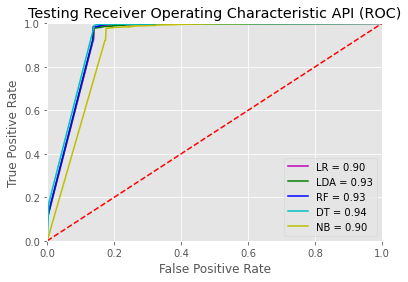

In [48]:
# testing roc curves
y_pred_test_prob = lr.predict_proba(X_test)[:,1]
fpr_tr_lr, tpr_tr_lr, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_lr, tpr_tr_lr)
plt.plot(fpr_tr_lr, tpr_tr_lr, 'm', label = 'LR = %0.2f' % roc_auc_train)
#####################################################################
y_pred_test_prob = lda.predict_proba(X_test)[:,1]
fpr_tr_lda, tpr_tr_lda, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_lda, tpr_tr_lda)
plt.plot(fpr_tr_lda, tpr_tr_lda, 'g', label = 'LDA = %0.2f' % roc_auc_test)
########################################################################
y_pred_test_prob = rf.predict_proba(X_test)[:,1]
fpr_tr_rf, tpr_tr_rf, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_rf, tpr_tr_rf)
plt.plot(fpr_tr_rf, tpr_tr_rf, 'b', label = 'RF = %0.2f' % roc_auc_test)
######################################################################
y_pred_test_prob = dt.predict_proba(X_test)[:,1]
fpr_tr_dt, tpr_tr_dt, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_dt, tpr_tr_dt)
plt.plot(fpr_tr_dt, tpr_tr_dt, 'c', label = 'DT = %0.2f' % roc_auc_test)
######################################################################
y_pred_test_prob = nb.predict_proba(X_test)[:,1]
fpr_tr_nb, tpr_tr_nb, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_nb, tpr_tr_nb)
plt.plot(fpr_tr_nb, tpr_tr_nb, 'y', label = 'NB = %0.2f' % roc_auc_test)
###########################################################################
# y_pred_test_prob = knn.predict_proba(X_test)[:,1]
# fpr_tr_knn, tpr_tr_knn, threshold = roc_curve(y_test, y_pred_test_prob)
# roc_auc_test = auc(fpr_tr_knn, tpr_tr_knn)
# plt.plot(fpr_tr_knn, tpr_tr_knn, 'k', label = 'KNN = %0.2f' % roc_auc_test)
###########################################################################
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Testing Receiver Operating Characteristic API (ROC)')
plt.show()